**Identifying Simpsons Characters - Method Comparison
**

**Here I compare various different methods for identifying which Simpsons character is in a given image.
**


*Step 1: Import Modules*

In [1]:
from PIL import Image, ImageFilter, ImageStat
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2, glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy
import PIL
import os
import itertools
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve, KFold, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import sklearn
from sklearn.metrics import confusion_matrix
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
import keras
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D, Activation
from keras.optimizers import RMSprop, SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback, EarlyStopping

from keras import backend as K
%matplotlib inline
#os.chdir('/kaggle/input/the-simpsons-characters-dataset/kaggle_simpson_testset')
os.chdir('/kaggle/input/zipfiles/kaggle_simpson_testset/kaggle_simpson_testset')

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


*Step 2: Describe Data*

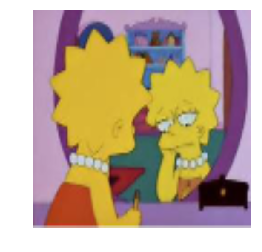

In [2]:
# Plot Image
image_name = "/kaggle/input/zipfiles/kaggle_simpson_testset/kaggle_simpson_testset/lisa_simpson_18.jpg" #Image to be used as query
def plotLisa(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (512,512))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotLisa(image_name)

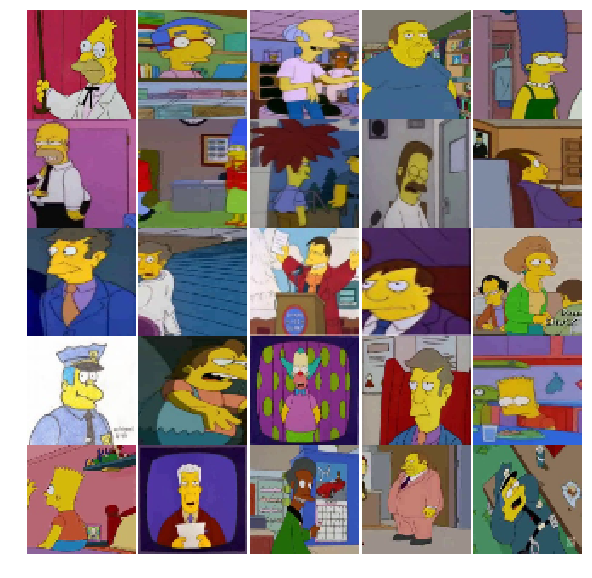

In [3]:
# Plot Multiple Images
simpsons = glob.glob('/kaggle/input/zipfiles/kaggle_simpson_testset/kaggle_simpson_testset/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in simpsons[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (64, 64)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

*Step 3: Preprocess Data*

In [4]:
## Load and Compress/Resize Test Data
dict_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lenny_leonard', 11:'lisa_simpson',
        12: 'marge_simpson', 13: 'mayor_quimby',14:'milhouse_van_houten', 15: 'moe_szyslak', 
        16: 'ned_flanders', 17: 'nelson_muntz', 18: 'principal_skinner', 19: 'sideshow_bob'}
def load_test_set(dirname,dict_characters):
    X_test = []
    Y_test = []
    for image_name in os.listdir(dirname):
        character_name = "_".join(image_name.split('_')[:-1])
        label = [label for label,character in dict_characters.items() if character == character_name][0]
        image = scipy.misc.imread(dirname+'/'+image_name)
        X_test.append(scipy.misc.imresize(image,(64,64),interp='lanczos'))
        Y_test.append(label)
    return np.array(X_test), np.array(Y_test)
X_test, Y_test = load_test_set("/kaggle/input/zipfiles/kaggle_simpson_testset/kaggle_simpson_testset", dict_characters)
# I will begin by working with the testing dataset only. Later I will load the training dataset as well.
X = X_test
y = Y_test
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
# Reduce Sample Size for DeBugging
X_train = X_train[0:1000] 
Y_train = Y_train[0:1000]
X_test = X_test[0:1000] 
Y_test = Y_test[0:1000]
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
print("Training Data Shape:", X_train.shape, X_train.shape)
print("Testing Data Shape:", X_test.shape, X_test.shape)
# Make Data 1D for compatability with standard classifiers
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 20)
Y_testHot = to_categorical(Y_test, num_classes = 20)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


Training Data Shape: (792, 64, 64, 3) (792, 64, 64, 3)
Testing Data Shape: (198, 64, 64, 3) (198, 64, 64, 3)


*Step 4: Define Helper Functions*

In [5]:
map_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
        11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
        14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'}

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# class MetricsCheckpoint(Callback):
#     """Callback that saves metrics after each epoch"""
#     def __init__(self, savepath):
#         super(MetricsCheckpoint, self).__init__()
#         self.savepath = savepath
#         self.history = {}
#     def on_epoch_end(self, epoch, logs=None):
#         for k, v in logs.items():
#             self.history.setdefault(k, []).append(v)
#         np.save(self.savepath, self.history)

# def plotKerasLearningCurve():
#     plt.figure(figsize=(10,5))
#     metrics = np.load('logs.npy')[()]
#     filt = ['acc'] # try to add 'loss' to see the loss learning curve
#     for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
#         l = np.array(metrics[k])
#         plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
#         x = np.argmin(l) if 'loss' in k else np.argmax(l)
#         y = l[x]
#         plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
#         plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
#     plt.legend(loc=4)
#     plt.axis([0, None, None, None]);
#     plt.grid()
#     plt.xlabel('Number of epochs')

*Step 5: Compare Classification Algorithms*

LogisticRegression - Training set accuracy: 0.20763157894736844 (0.08938424322154374)



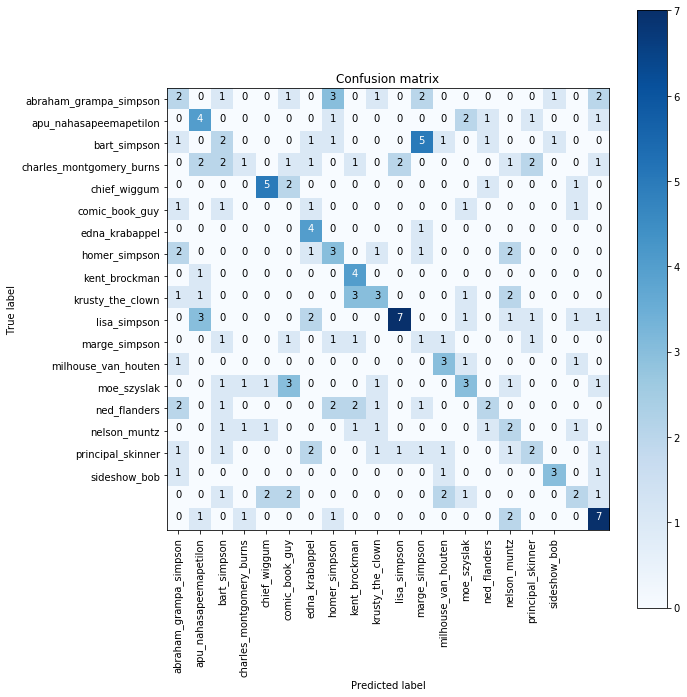

In [6]:
def runLogisticRegression(a,b,c,d):
    """Run LogisticRegression w/ Kfold CV"""
    model = LogisticRegression()
    model.fit(a,b)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('LogisticRegression - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')
    prediction = model.predict(c)
    cnf_matrix = confusion_matrix(d, prediction)
    np.set_printoptions(precision=2)
    class_names = dict_characters 
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=list(map_characters.values()),title='Confusion matrix')
runLogisticRegression(X_trainFlat, Y_train, X_testFlat, Y_test)

There are 20 different characters.  If we were guessing by random chance, 
we should have about 5% accuracy.  Here we can see that a simple Logistic Regression
already can predict with approximately five times the accuracy of random chance.
Next I will evaluate the performance of some other classification algorithms.


Compare Multiple Classifiers:

Accuracy:

LR: 0.305570 (0.041558)
RF: 0.248703 (0.038943)
KNN: 0.180633 (0.036570)
SVM: 0.073149 (0.027865)
LSVM: 0.296677 (0.047021)
GNB: 0.271535 (0.034489)
DTC: 0.200744 (0.035884)


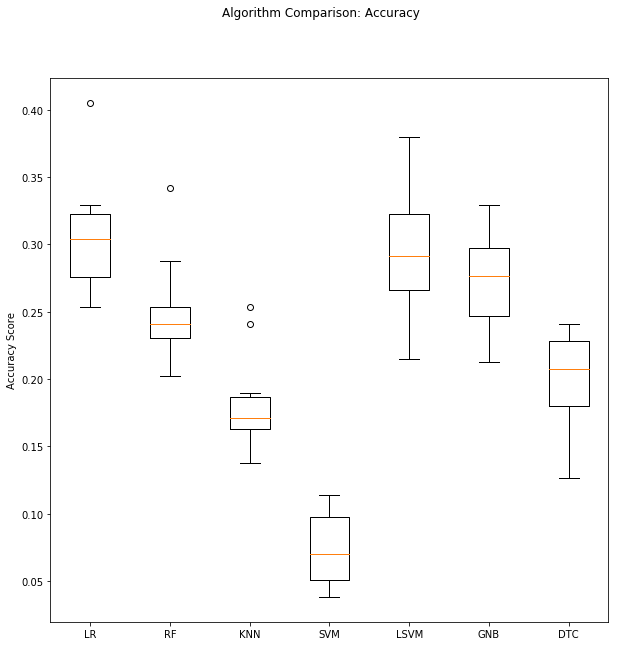


LR = LogisticRegression
RF = RandomForestClassifier
KNN = KNeighborsClassifier
SVM = Support Vector Machine SVC
LSVM = LinearSVC
GNB = GaussianNB
DTC = DecisionTreeClassifier



In [7]:
# Compare Performance of Classification Algorithms
def compareABunchOfDifferentModelsAccuracy(a,b,c,d):
    """
    compare performance of classifiers on X_train, X_test, Y_train, Y_test
    http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
    http://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
    """    
    print('\nCompare Multiple Classifiers:\n')
    print('Accuracy:\n')
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVM', SVC()))
    models.append(('LSVM', LinearSVC()))
    models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
    #models.append(('GBC', GradientBoostingClassifier()))
    #models.append(('LDA', LinearDiscriminantAnalysis()))       
    resultsAccuracy = []
    names = []
    for name, model in models:
        model.fit(a, b)
        kfold = model_selection.KFold(n_splits=10)
        accuracy_results = model_selection.cross_val_score(model, a, b, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)  
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Accuracy Score')
    plt.show()
    return
compareABunchOfDifferentModelsAccuracy(X_trainFlat, Y_train, X_testFlat, Y_test)

def defineModels():
    print('\nLR = LogisticRegression')
    print('RF = RandomForestClassifier')
    print('KNN = KNeighborsClassifier')
    print('SVM = Support Vector Machine SVC')
    print('LSVM = LinearSVC')
    print('GNB = GaussianNB')
    print('DTC = DecisionTreeClassifier')
    #print('GBC = GradientBoostingClassifier')
    #print('LDA = LinearDiscriminantAnalysis')
    print('')
defineModels()

These methods can perform more than four times better than random chance.
Eventually we will do much better.  Next I will try to increase the accuracy by increasing the sample size a little bit. 
Beceause of the limitations of the Kaggle Kernel, however, I still will not be using the full dataset.
With this larger sample size I should be able to use neural networks with some success.

In [8]:
img_size = 64
# Load and Compress/Resize Test Data
dict_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lenny_leonard', 11:'lisa_simpson',
        12: 'marge_simpson', 13: 'mayor_quimby',14:'milhouse_van_houten', 15: 'moe_szyslak', 
        16: 'ned_flanders', 17: 'nelson_muntz', 18: 'principal_skinner', 19: 'sideshow_bob'}
def load_test_set(dirname,dict_characters):
    X_test = []
    Y_test = []
    for image_name in os.listdir(dirname):
        character_name = "_".join(image_name.split('_')[:-1])
        label = [label for label,character in dict_characters.items() if character == character_name][0]
        image = scipy.misc.imread(dirname+'/'+image_name)
        X_test.append(scipy.misc.imresize(image,(img_size,img_size),interp='lanczos'))
        Y_test.append(label)
    return np.array(X_test), np.array(Y_test)
X_test, Y_test = load_test_set("/kaggle/input/zipfiles/kaggle_simpson_testset/kaggle_simpson_testset", dict_characters) 

from os import listdir
directory_name = "/kaggle/input/zipfiles/simpsons_dataset/simpsons_dataset"

def load_train_set(dirname,dict_characters):
   X_train = []
   Y_train = []
   for label,character in dict_characters.items():
       list_images = os.listdir(dirname+'/'+character)
       for image_name in list_images[0:150]:
           image = scipy.misc.imread(dirname+'/'+character+'/'+image_name)
           X_train.append(scipy.misc.imresize(image,(img_size,img_size),interp='lanczos'))
           Y_train.append(label)
   return np.array(X_train), np.array(Y_train)
X_train, Y_train = load_train_set("/kaggle/input/zipfiles/simpsons_dataset/simpsons_dataset", dict_characters)       
# Normalize the data
X_train = X_train / 255.0
print("Train", X_train.shape, Y_train.shape)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Train (3000, 64, 64, 3) (3000,)


In [9]:
# Split data for cross validation
X_test, Y_test = load_test_set("/kaggle/input/zipfiles/kaggle_simpson_testset/kaggle_simpson_testset", dict_characters) 
X_train, Y_train = load_train_set("/kaggle/input/zipfiles/simpsons_dataset/simpsons_dataset", dict_characters)       
# Reduce Sample Size for DeBugging 
X_train = X_train[0:3000] 
Y_train = Y_train[0:3000]
X_test = X_test[0:1000] 
Y_test = Y_test[0:1000]
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
print("Training Data Shape:", X_train.shape, X_train.shape)
print("Testing Data Shape:", X_test.shape, X_test.shape)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 20)
Y_test = to_categorical(Y_test, num_classes = 20)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Training Data Shape: (3000, 64, 64, 3) (3000, 64, 64, 3)
Testing Data Shape: (990, 64, 64, 3) (990, 64, 64, 3)


Epoch 1/16
94/93 [==============================] - 10s 105ms/step - loss: 2.9991 - acc: 0.0480
Epoch 2/16
94/93 [==============================] - 6s 60ms/step - loss: 2.9721 - acc: 0.0649
Epoch 3/16
94/93 [==============================] - 6s 59ms/step - loss: 2.8664 - acc: 0.1331
Epoch 4/16
94/93 [==============================] - 6s 60ms/step - loss: 2.7632 - acc: 0.1427
Epoch 5/16
94/93 [==============================] - 6s 59ms/step - loss: 2.7074 - acc: 0.1653
Epoch 6/16
94/93 [==============================] - 6s 61ms/step - loss: 2.6535 - acc: 0.1902: 0s - loss: 2.6511 - acc: 0
Epoch 7/16
94/93 [==============================] - 6s 59ms/step - loss: 2.6152 - acc: 0.1939
Epoch 8/16
94/93 [==============================] - 6s 60ms/step - loss: 2.5531 - acc: 0.2091
Epoch 9/16
94/93 [==============================] - 6s 60ms/step - loss: 2.4809 - acc: 0.2381
Epoch 10/16
94/93 [==============================] - 6s 60ms/step - loss: 2.3787 - acc: 0.2763
Epoch 11/16
94/93 [==========

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 20, does not match size of target_names, 18
  .format(len(labels), len(target_names))



                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.54      0.42      0.47        48
  apu_nahasapeemapetilon       0.40      0.88      0.55        50
            bart_simpson       0.67      0.20      0.31        50
charles_montgomery_burns       0.61      0.46      0.52        48
            chief_wiggum       0.42      0.88      0.56        50
          comic_book_guy       0.63      0.53      0.58        49
          edna_krabappel       0.52      0.74      0.61        50
           homer_simpson       0.54      0.50      0.52        50
           kent_brockman       0.68      0.76      0.72        50
        krusty_the_clown       0.63      0.54      0.58        50
            lisa_simpson       0.36      0.62      0.46        50
           marge_simpson       0.53      0.20      0.29        50
     milhouse_van_houten       0.59      0.80      0.68        50
             moe_szyslak       0.56      0.60      0.58        50
        

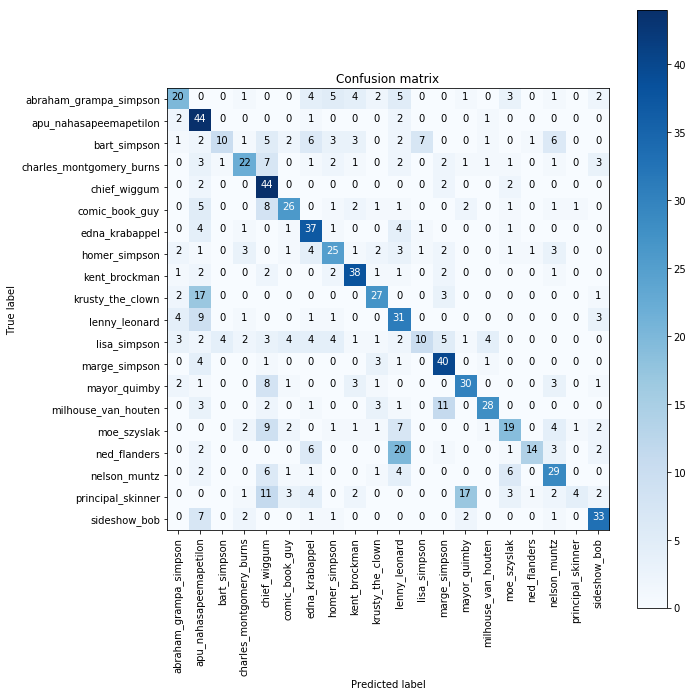

In [10]:
def kerasAugmentation(a,b,c,d):
    img_rows, img_cols = img_size,img_size
    input_shape = (img_rows, img_cols, 3)
    batch_size = 128
    num_classes = 20
    epochs = 16
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3), padding='same')) 
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    datagen.fit(a)
    model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs)
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #3B - accuracy:', score[1])
    print('')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))  
kerasAugmentation(X_train, Y_train, X_test, Y_test)

Now the accuracy is about 50%.

Train on 3000 samples, validate on 990 samples
Epoch 1/16
3000/3000 [==============================] - 3s 1ms/step - loss: 3.0998 - acc: 0.0657 - val_loss: 2.9552 - val_acc: 0.1222
Epoch 2/16
3000/3000 [==============================] - 2s 760us/step - loss: 2.9268 - acc: 0.1137 - val_loss: 2.8415 - val_acc: 0.1970
Epoch 3/16
3000/3000 [==============================] - 2s 757us/step - loss: 2.7404 - acc: 0.1880 - val_loss: 2.5206 - val_acc: 0.2596
Epoch 4/16
3000/3000 [==============================] - 2s 756us/step - loss: 2.5643 - acc: 0.2343 - val_loss: 2.3618 - val_acc: 0.3616
Epoch 5/16
3000/3000 [==============================] - 2s 763us/step - loss: 2.3366 - acc: 0.3150 - val_loss: 2.2086 - val_acc: 0.4192
Epoch 6/16
3000/3000 [==============================] - 2s 765us/step - loss: 2.1793 - acc: 0.3540 - val_loss: 1.9894 - val_acc: 0.4737
Epoch 7/16
3000/3000 [==============================] - 2s 756us/step - loss: 1.9891 - acc: 0.4147 - val_loss: 1.9535 - val_acc: 0.4273
Epo

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 20, does not match size of target_names, 18
  .format(len(labels), len(target_names))



                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.52      0.48      0.50        48
  apu_nahasapeemapetilon       0.77      0.74      0.76        50
            bart_simpson       0.47      0.46      0.46        50
charles_montgomery_burns       0.60      0.44      0.51        48
            chief_wiggum       0.83      0.76      0.79        50
          comic_book_guy       0.69      0.78      0.73        49
          edna_krabappel       0.75      0.66      0.70        50
           homer_simpson       0.30      0.54      0.39        50
           kent_brockman       0.67      0.82      0.74        50
        krusty_the_clown       0.83      0.68      0.75        50
            lisa_simpson       0.94      0.62      0.75        50
           marge_simpson       0.50      0.18      0.26        50
     milhouse_van_houten       0.78      0.76      0.77        50
             moe_szyslak       0.76      0.90      0.83        50
        

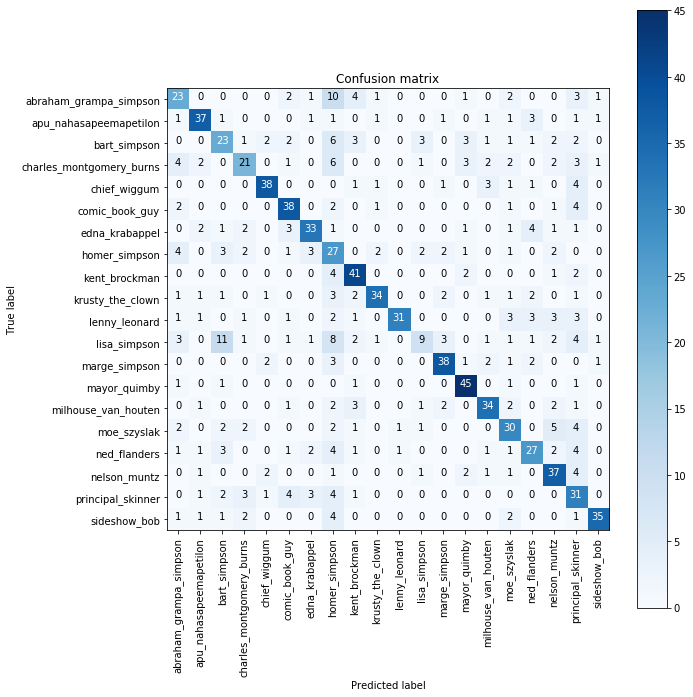

In [11]:
def runKerasCNN(a,b,c,d):
    batch_size = 128
    num_classes = 20
    epochs = 16
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.fit(a,b,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(c,d))
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1B - accuracy:', score[1])
    print('')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
runKerasCNN(X_train, Y_train,  X_test, Y_test)

Great!  We got the accuracy to ~60% (for identifying each of twenty different Simpsons characters).

Epoch 1/40
94/93 [==============================] - 7s 76ms/step - loss: 3.5755 - acc: 0.1413
Epoch 2/40
94/93 [==============================] - 6s 61ms/step - loss: 2.7107 - acc: 0.2400
Epoch 3/40
94/93 [==============================] - 6s 61ms/step - loss: 2.3903 - acc: 0.3155
Epoch 4/40
94/93 [==============================] - 6s 61ms/step - loss: 2.1698 - acc: 0.3758
Epoch 5/40
94/93 [==============================] - 6s 61ms/step - loss: 1.9786 - acc: 0.4337
Epoch 6/40
94/93 [==============================] - 6s 61ms/step - loss: 1.8210 - acc: 0.4731
Epoch 7/40
94/93 [==============================] - 6s 59ms/step - loss: 1.7683 - acc: 0.4894
Epoch 8/40
94/93 [==============================] - 6s 61ms/step - loss: 1.6514 - acc: 0.5337
Epoch 9/40
94/93 [==============================] - 6s 64ms/step - loss: 1.5389 - acc: 0.5493
Epoch 10/40
94/93 [==============================] - 6s 64ms/step - loss: 1.4917 - acc: 0.5658
Epoch 11/40
94/93 [==============================] - 6s 65m

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 20, does not match size of target_names, 18
  .format(len(labels), len(target_names))



                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.63      0.71      0.67        48
  apu_nahasapeemapetilon       0.87      0.94      0.90        50
            bart_simpson       0.55      0.54      0.55        50
charles_montgomery_burns       0.93      0.56      0.70        48
            chief_wiggum       0.93      0.80      0.86        50
          comic_book_guy       0.81      0.69      0.75        49
          edna_krabappel       0.94      0.66      0.78        50
           homer_simpson       0.67      0.60      0.63        50
           kent_brockman       0.90      0.88      0.89        50
        krusty_the_clown       0.76      1.00      0.86        50
            lisa_simpson       0.92      0.88      0.90        50
           marge_simpson       0.38      0.68      0.49        50
     milhouse_van_houten       0.75      0.94      0.83        50
             moe_szyslak       0.87      0.90      0.88        50
        

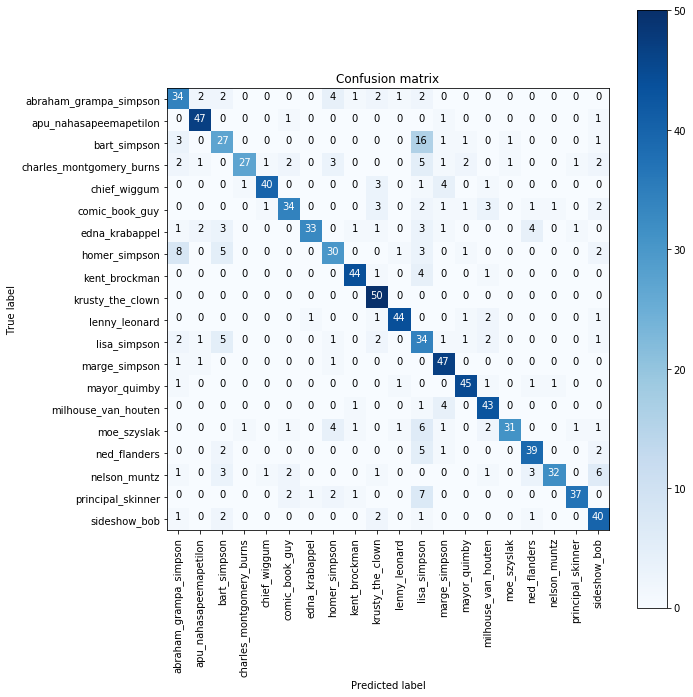

In [12]:
def runAnotherKerasAugmented(a,b,c,d):
    batch_size = 128
    num_classes = 20
    epochs = 40
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    #model.add(Dense(1024, activation = "relu"))
    #model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation = "softmax"))
    # Define the optimizer
    optimizer = RMSprop(lr=0.001, decay=1e-6)
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    datagen.fit(a)
    model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs)
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2B - accuracy:', score[1])
    print('')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))  
runAnotherKerasAugmented(X_train, Y_train, X_test, Y_test)


**Great!  In the end, we were able to identify which of the twenty Simpsons characters
were present in each given image and we were able to do this with approximately 80% accuracy.
**


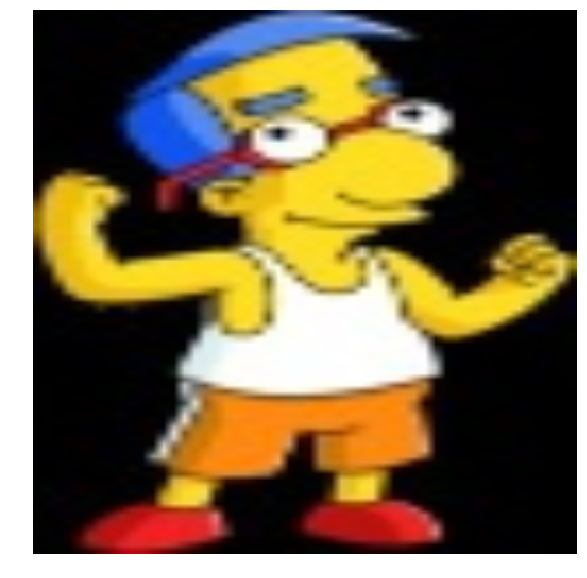

In [13]:
image_name = "/kaggle/input/zipfiles/kaggle_simpson_testset/kaggle_simpson_testset/milhouse_van_houten_46.jpg" #Image to be used as query
def plotMilhouse(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (512,512))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotMilhouse(image_name)